# Job Finder

This notebook creates a model, to recommend job positions given a position requirements description .

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.



In [ ]:
import pandas as pd

# Reading the CSV file
df = pd.read_csv('/content/jobs_info.csv', encoding='utf-8')
print(df.columns)

# Create JobDescription column using Key Skills + Role Category + Functional Area
df['JobDescription'] = (
    df['Key Skills'].astype(str) + " " +
    df['Role Category'].astype(str) + " " +
    df['Functional Area'].astype(str)
)

# Rename Job Title → Title (for your ML model)
df['Title'] = df['Job Title']

# Select columns your ML model wants
cols = ['Title', 'JobDescription']
df = df[cols]

print(df.head())


Index(['job id', 'company id', 'Job Salary', 'Job Experience', 'Key Skills',
       'Role Category', 'Functional Area', 'Industry', 'Job Title'],
      dtype='object')
                        Title  \
0     Sales Executive/Officer   
1  Technical Support Engineer   
2            Testing Engineer   
3              System Analyst   
4         Technical Architect   

                                      JobDescription  
0   pre sales| closing| software knowledge| clien...  
1   Technical Support Admin/Maintenance/Security/...  
2   manual testing| test engineering| test cases|...  
3   adobe experience manager| digital| digital ma...  
4   TFS| Azure| Git| VSTS| Docker| DynaTrace| Spl...  


In [ ]:
# Display basic information about the dataset
print("Data Information:")
print(data.info())





Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9598 entries, 0 to 9597
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job id           9598 non-null   int64 
 1   company id       9598 non-null   int64 
 2   Job Salary       9598 non-null   object
 3   Job Experience   9598 non-null   object
 4   Key Skills       9598 non-null   object
 5   Role Category    9598 non-null   object
 6   Functional Area  9598 non-null   object
 7   Industry         9598 non-null   object
 8   Job Title        9598 non-null   object
dtypes: int64(2), object(7)
memory usage: 675.0+ KB
None


In [ ]:
# Checking for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
job id             0
company id         0
Job Salary         0
Job Experience     0
Key Skills         0
Role Category      0
Functional Area    0
Industry           0
Job Title          0
dtype: int64


# Modifying Job Titles
Selecting only top 21 job titles, to manage class imbalance

In [ ]:
classes = df['Title'].value_counts()[:21]
keys = classes.keys().to_list()

df = df[df['Title'].isin(keys)]
df['Title'].value_counts()

,count
Title,
Software Developer,4250
Associate/Senior Associate -(NonTechnical),532
Team Lead/Technical Lead,505
Sales/Business Development Manager,305
Associate/Senior Associate -(Technical),269
Testing Engineer,267
Technical Architect,244
Sales Executive/Officer,209
System Administrator,175


Change job titles to base title. For exmaple, chaning Senior Java Developer to Java Developer.   

In [ ]:
def chane_titles(x):
    x = x.strip()
    if x == 'Senior Java Developer':
        return 'Java Developer'
    elif x == 'Senior Software Engineer':
        return 'Software Engineer'
    elif x == 'Senior QA Engineer':
        return 'Software QA Engineer'
    elif x == 'Senior Software Developer':
        return 'Senior Web Developer'
    elif x =='Senior PHP Developer':
        return 'PHP Developer'
    elif x == 'Senior .NET Developer':
        return '.NET Developer'
    elif x == 'Senior Web Developer':
        return 'Web Developer'
    elif x == 'Database Administrator':
        return 'Database Admin/Dev'
    elif x == 'Database Developer':
        return 'Database Admin/Dev'

    else:
        return x


df['Title'] = df['Title'].apply(chane_titles)
df['Title'].value_counts()

,count
Title,
Software Developer,4250
Associate/Senior Associate -(NonTechnical),532
Team Lead/Technical Lead,505
Sales/Business Development Manager,305
Associate/Senior Associate -(Technical),269
Testing Engineer,267
Technical Architect,244
Sales Executive/Officer,209
System Administrator,175


Data Visualisation


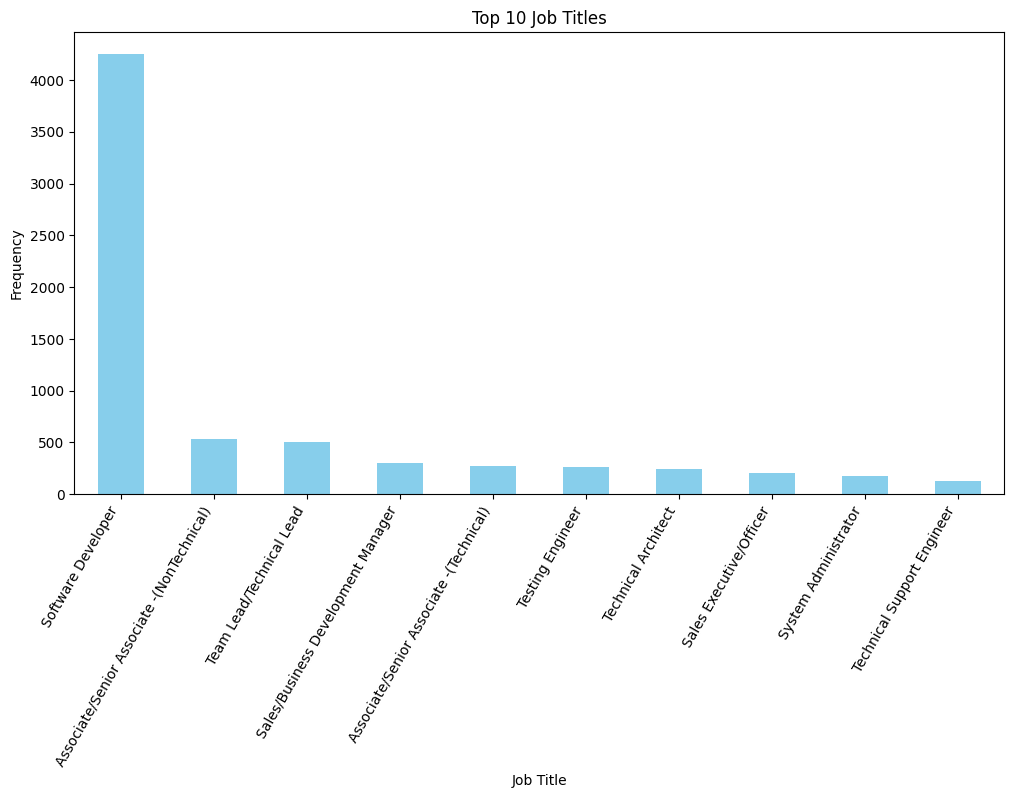

In [ ]:

# Set a larger figure size for more space
plt.figure(figsize=(12, 6))

# Plot with the top 10 job titles, using value_counts
data['Job Title'].value_counts().head(10).plot(kind='bar', color='skyblue')

# Adding title and labels
plt.title('Top 10 Job Titles')
plt.xlabel('Job Title')
plt.ylabel('Frequency')

# Adjust the rotation and font size for better readability
plt.xticks(rotation=60, ha='right', fontsize=10)

# Display the plot
plt.show()


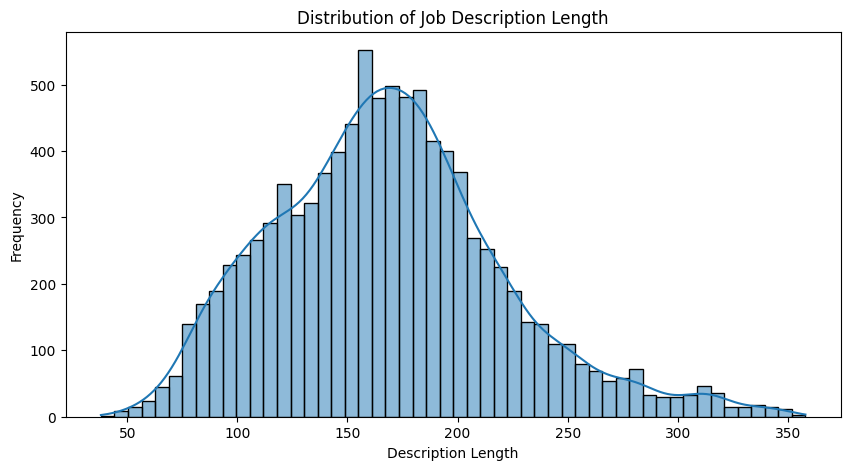

In [ ]:
# Create JobDescription column from existing fields
data['JobDescription'] = (
    data['Key Skills'].astype(str) + " " +
    data['Role Category'].astype(str) + " " +
    data['Functional Area'].astype(str)
)
# Length of Job Descriptions
data['JobDescription_length'] = data['JobDescription'].apply(lambda x: len(str(x)))

plt.figure(figsize=(10, 5))
sns.histplot(data['JobDescription_length'], kde=True)
plt.title('Distribution of Job Description Length')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()


# Building custom tokenizer to process text

In [ ]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# -------------------------------
# 1. Load CSV
# -------------------------------
df = pd.read_csv("/content/jobs_info.csv")

# Clean column names
df.columns = df.columns.str.strip()

# -------------------------------
# 2. Rename Job Title → Title
# -------------------------------
df = df.rename(columns={'Job Title': 'Title'})

# -------------------------------
# 3. Create JobDescription
# -------------------------------
df['JobDescription'] = (
    df['Key Skills'].astype(str) + " " +
    df['Role Category'].astype(str) + " " +
    df['Functional Area'].astype(str)
)

# -------------------------------
# 4. Create RequiredQual
# -------------------------------
df['RequiredQual'] = df['Job Experience'].astype(str)

df['RequiredQual'] = df['RequiredQual'].apply(
    lambda x: x.replace('\n', ' ')
               .replace('\r', '')
               .replace('- ', '')
               .replace(' - ', ' to ')
)

# -------------------------------
# 5. Tokenizer
# -------------------------------
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.stopwords = stopwords.words('english')

    def __call__(self, doc):
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc.lower())
            if t not in self.stopwords
        ]

# --------------------


In [ ]:
print(df.columns.tolist())


['Title', 'JobDescription']


# Featurizing Text

In [ ]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')   # <<< IMPORTANT NEW ADDITION
nltk.download('wordnet')

# -------------------------------
# Tokenizer with lemmatization + lowercase + stopwords
# -------------------------------
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.stopwords = set(stopwords.words('english'))

    def __call__(self, doc):
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc.lower())
            if t not in self.stopwords
        ]

# -------------------------------
# 1. Features (text) and labels
# -------------------------------
X = df['JobDescription']
y = df['Title']

# -------------------------------
# 2. TF-IDF Vectorizer
# -------------------------------
vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer())
vectorizer.fit(X)

# -------------------------------
# 3. Encode labels
# -------------------------------
enc = LabelEncoder()
y_enc = enc.fit_transform(y)

# -------------------------------
# 4. Train-test split
# -------------------------------
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.15, random_state=10
)

# -------------------------------
# 5. Transform AFTER splitting
# -------------------------------
X_train = vectorizer.transform(X_train_text).toarray()
X_test = vectorizer.transform(X_test_text).toarray()

# -------------------------------
# Print shapes for confirmation
# -------------------------------
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Labels:", len(y_enc))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Train shape: (8158, 4976)
Test shape: (1440, 4976)
Labels: 9598


# Training Naive Bayes
Looks pretty overfit

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
gnb = GaussianNB()
train_preds = gnb.fit(X_train, y_train).predict(X_train)
test_preds = gnb.predict(X_test)

print('Train acc: {0}'.format(accuracy_score(y_train, train_preds)))
print('Test acc: {0}'.format(accuracy_score(y_test, test_preds)))


Train acc: 0.728242216229468
Test acc: 0.35833333333333334


# Training Logistic Regression
By modifiying the maximum number of iterations, and regularization, C, the above experienced overfitting was reduced significantly


In [ ]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(max_iter=100,verbose=1, C=0.75)

train_preds = logistic.fit(X_train, y_train).predict(X_train)
test_preds = logistic.predict(X_test)

print('Train acc: {0}'.format(accuracy_score(y_train, train_preds)))
print('Test acc: {0}'.format(accuracy_score(y_test, test_preds)))


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min finished


Train acc: 0.7188036283402794
Test acc: 0.6611111111111111


# Creating Job Recommendations
Recommends 2 job position alternatives given a job requirement. By obtaining probability of class predictions, and picking the top N predictions, other than true label, N closest recommendations can be got

In [ ]:
import numpy as np

# Dictionary for storing recommendation results
preds_data = {
    'Current Position Requirements': [],
    'Current Position': [],
    'Alternative 1': [],
    'Alternative 2': []
}

# Predicted probabilities for each class
y_preds_proba = logistic.predict_proba(X_test)

# Convert numerical labels → job titles
inverse = enc.inverse_transform

# Iterate through test rows
for idx, (prob_row, true_label) in enumerate(zip(y_preds_proba, y_test)):

    # Sort classes by probability (highest → lowest)
    sorted_classes = np.argsort(prob_row)[::-1]

    # Remove the true class from recommendations
    sorted_classes = [c for c in sorted_classes if c != true_label]

    # Pick top 2 alternative classes
    alt1, alt2 = sorted_classes[:2]
    alt1_name, alt2_name = inverse([alt1, alt2])

    # True class name
    true_name = inverse([true_label])[0]

    # Save original requirement text (X_test_text, not vectors!)
    preds_data['Current Position Requirements'].append(X_test_text.iloc[idx])
    preds_data['Current Position'].append(true_name)
    preds_data['Alternative 1'].append(alt1_name)
    preds_data['Alternative 2'].append(alt2_name)


In [ ]:
preds_df = pd.DataFrame.from_dict(preds_data)
preds_df.to_csv('Recommendations.csv', index=False)
preds_df


,Current Position Requirements,Current Position,Alternative 1,Alternative 2
0,agile| elastic search| C#| WPF| WCF| Entity F...,Software Developer,Sales Trainer,Staffing Specialist/ Manpower Planning
1,Product engineering| Analytical| Machine lear...,Research Scientist,Sales Trainer,Staffing Specialist/ Manpower Planning
2,Lead generation| Word| Excel| Conversions| MS...,Sales Executive/Officer,Research Scientist,Regional Manager
3,Data Integration| Pentaho| Data Management Ot...,Outside Consultant,Sales Trainer,DBA
4,Networking| Computer Hardware| Patch Managemen...,IT/Networking-Manager,Social Media Marketing Manager,Sales Trainer
...,...,...,...,...
1435,SQL| XML| Ajax| c#| server| development| C| s...,Software Developer,Sales Trainer,Staffing Specialist/ Manpower Planning
1436,tech support| BPO| voice| Help Desk| Customer...,Associate/Senior Associate -(Technical),Assistant Professor,Associate/Senior Associate -(NonTechnical)
1437,Ethical Hacking| Cyber Security| OSCP| SIEM| ...,System Security,Software Developer,Social Media Marketing Manager
1438,spring| corejava| rest| web services| j2ee| hi...,Software Developer,Sales Trainer,Staffing Specialist/ Manpower Planning


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions
y_pred = logistic.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision (macro):", precision)
print("Recall (macro):", recall)
print("F1 Score (macro):", f1)


Accuracy: 0.6611111111111111
Precision (macro): 0.21030047936811327
Recall (macro): 0.19016284662330105
F1 Score (macro): 0.1776331308922991


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
